In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy


In [2]:
iterations = 100

# (x, y, theta)
states = [np.array([0.0, 0.0, 0.0])]
controls = []
observations = []

beacon_observer = dpf_toy.BeaconObserver()
beacon_observer.add_beacon((5, 3), 0.2)
beacon_observer.add_beacon((22, 8), 0.5)

dynamics = dpf_toy.RobotDynamicsModel()

# Simulation
for _ in range(iterations):
    control = torch.from_numpy(np.random.uniform(
        low=[0, -0.1], high=[1, 0.1], size=(2,)).astype(np.float32))
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=True)

    states.append(new_state[0].numpy())
    controls.append(control.numpy())
true_states = np.array(states)

# Dead-reckoning
states = [true_states[0]]
for control in controls:
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
    states.append(new_state[0].numpy())
dead_reckoned_states = np.array(states)


In [3]:

# Particle filter network
dynamics = dpf_toy.RobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()

torch.autograd.set_detect_anomaly(True)

pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 0.5)
pfnet.train()


ParticleFilterNetwork(
  (dynamics_model): RobotDynamicsModel()
  (measurement_model): DeepBeaconMeasurementModel(
    (observation_layers): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (state_layers): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (shared_layers): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=1, bias=True)
      (7): LogSigmoid()
    )
  )
)

In [6]:
model = pfnet

total_epochs = 0
optimizer = optim.Adam(model.parameters())

def set_lr(lr):
    print("Setting learning rate to", lr)
    for g in optimizer.param_groups:
        g['lr'] = lr

def train(epoch, log_interval=10):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        start = time.time()

        observations = beacon_observer.forward(true_states[1:])
        states = [true_states[0]]
        num_particles = 1000
        prev_particle_states = torch.FloatTensor(
            [true_states[0] for _ in range(num_particles)])
        prev_particle_weights = torch.ones(num_particles)

        loss = torch.FloatTensor(0)
        
        for i, (control, observation) in enumerate(zip(controls, observations)):
            # Type conversions
            observation = torch.from_numpy(observation.astype(np.float32))
            control = torch.from_numpy(control.astype(np.float32))


            #loss = F.mse_loss(particle_states[:,:2],
            #                 torch.from_numpy(true_states[i + 1][np.newaxis,:2].astype(np.float32)))
            # Particle filter network: forward
            best_state, particle_states, particle_weights = pfnet.forward(
                prev_particle_states, prev_particle_weights, observation, control)

            loss += F.mse_loss(best_state, torch.from_numpy(true_states[i+1].astype(np.float32)))

            prev_particle_states = particle_states
            prev_particle_weights = particle_weights
            
            if i % 5 == 0:
                # Backward pass
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

        print()



        end = time.time()

        global total_epochs
        total_epochs += 1
        print('{}: {:.2f}s'.format(total_epochs, end-start))

In [15]:
set_lr(1e-4)
train(10)

Setting learning rate to 0.0001
Losses: 	 0.3409429	 0.06247653	 0.021921372	 0.01037909	 0.013366989
Losses: 	 0.112154186	 0.6599075	 2.7755115	 5.815807	 8.570806
Losses: 	 7.30528	 5.048078	 3.23763	 2.048273	 1.2368402
Losses: 	 2.6744335	 1.3957709	 0.6358086	 0.31335554	 0.17914979
Losses: 	 0.19365782	 0.2063651	 0.23417282	 0.25679296	 0.25702208
Losses: 	 0.37347448	 0.5956528	 0.9312641	 1.4041368	 2.2390523
Losses: 	 1.2567928	 0.91938126	 0.70411056	 0.54555804	 0.40639326
Losses: 	 0.12640718	 0.11639469	 0.107430905	 0.10858813	 0.12147833
Losses: 	 0.03649043	 0.05024947	 0.066541575	 0.08498416	 0.112659104
Losses: 	 0.070789956	 0.07881739	 0.08156066	 0.087916896	 0.0938764
Losses: 	 0.13814586	 0.16152938	 0.19200845	 0.22431102	 0.26344165
Losses: 	 0.39600915	 0.34654272	 0.29416654	 0.25501317	 0.22574314
Losses: 	 0.23853993	 0.25087678	 0.2646413	 0.27913475	 0.29977882
Losses: 	 0.31714538	 0.30448234	 0.28640085	 0.28841105	 0.2774586
Losses: 	 0.3250761	 0.3

KeyboardInterrupt: 

In [8]:
observations = beacon_observer.forward(true_states[1:])
states = [true_states[0]]
num_particles = 1000
particle_states = torch.FloatTensor(
    [true_states[0] for _ in range(num_particles)])
particle_weights = torch.ones(num_particles)

end = 100
for control, observation in zip(controls[:end], observations[:end]):
    # Type conversions
    observation = torch.from_numpy(observation.astype(np.float32))
    control = torch.from_numpy(control.astype(np.float32))

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control)

    states.append(best_state.detach().numpy())
pf_states = np.array(states)


In [16]:
def plot():
    # Plot trajectories
    plt.scatter(dead_reckoned_states[:, 0],
                dead_reckoned_states[:, 1], marker=".", label="Dead-reckoned")
    plt.scatter(true_states[:, 0], true_states[:, 1],
                marker=".", label="Ground-truth")
    plt.scatter(pf_states[:, 0], pf_states[:, 1],
                marker=".", label="Particle Filter")
    # print(pf_states)

    plt.scatter(particle_states.numpy()[:, 0], particle_states.numpy()[:, 1], marker=".", label="Particles")

    # Plot beacons
    beacon_locations = np.asarray(beacon_observer.locations)
    plt.scatter(beacon_locations[:, 0], beacon_locations[:, 1], label="Beacons")

    plt.legend()
    plt.show()

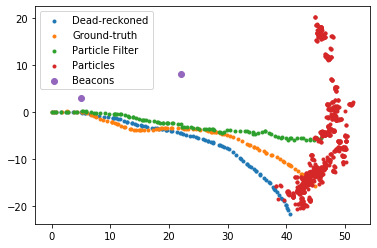

In [18]:
plot()

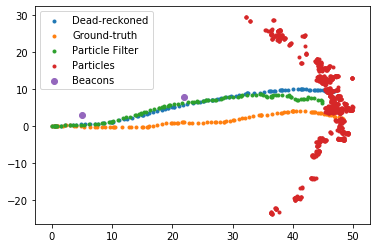

In [42]:
plot()